In [5]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness, RandomTranslation

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

PATH = "C:/Users/Matthias/Downloads/gesture_dataset_sample/gesture_dataset_sample/"

## helper function to load and parse annotations

In [6]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [7]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [8]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

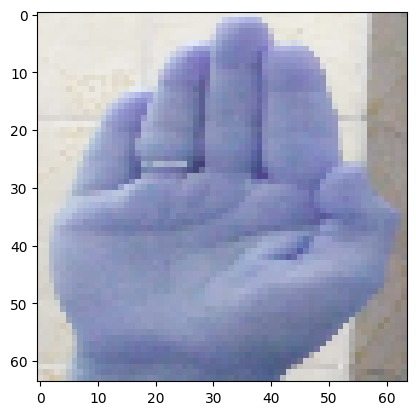

In [6]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [10]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


## Approach

### Data Augmentation

Keras allows for different data augmentation layers. The 'RandomCrop' and 'RandomZoom' layers were not chosen to use, since these would not keep the most important features (hands) in full size in the image, and are expected to perform very bad because of that. I choose to test out the differences in performances of different other layers, they were not combined but used in isolation, since I find it interesting to see if some of them can lead to unexpectedly good results:

- 'RandomFlip': This layer allows for different modes. In this test, I flipped the images vertically and horizontally, expecting that this will perform worse than the baseline since the different classes, especially when they are inherently similar like like/dislike, will be harder to differentiate
- 'RandomTranslation': this should perform worse than the baseline, since it will shift the positions of the hand
- 'RandomRotation': Similiar to randomFlip, since it changes the position it could lead to harder differentiation
- 'RandomContrast': Should perform similiar to the baseline, since the hand as the main feature should still be distinguishable and the classifier should differentiate classes the same way
- 'RandomBrightness': should perform worse than the baseline, since a too high or low brightness leads to many pixels having the same value, which complicates the classification 

In [11]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# Function that receives a dataAugmentation layer and inserts it into the model
def create_model(dataAugmentation): 
        

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    if dataAugmentation is not None:
        model.add(dataAugmentation)

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    return model

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# Creation of the models and training

In [12]:
# different models
model_randomFlip = create_model(RandomFlip('horizontal_and_vertical'))
model_randomContrast = create_model(RandomContrast(0.1))
model_randomBrightness = create_model(RandomBrightness(0.1))
model_randomRotation = create_model(RandomRotation(0.2))
model_randomTranslation = create_model(RandomTranslation(0.1,0.1))
model_baseline = create_model(None)

models = [{"model": model_baseline, "name": "baseline"}, {"model": model_randomFlip, "name": "randomFlip"}, {"model": model_randomContrast, "name": "randomContrast"}, 
          {"model": model_randomBrightness, "name": "randomBrightness"}, {"model": model_randomRotation, "name": "randomRotation"}, {"model": model_randomTranslation, "name": "randomTranslation"}]


def train_models(models):
    histories = []

    for i in range(0, len(models)):
        history = models[i]["model"].fit(
            X_train,
            train_label,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_test, test_label),
            callbacks=[reduce_lr, stop_early]
        )

        histories.append({"history": history, "name": models[i]["name"]})

    return histories

In [13]:
histories = train_models(models)

Epoch 1/50
64/64 [==============================] - 6s 71ms/step - loss: 1.0526 - accuracy: 0.4473 - val_loss: 1.0431 - val_accuracy: 0.4297 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 4s 69ms/step - loss: 0.9856 - accuracy: 0.4902 - val_loss: 0.9589 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 4s 68ms/step - loss: 0.8374 - accuracy: 0.6348 - val_loss: 0.7150 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 5s 73ms/step - loss: 0.5426 - accuracy: 0.7910 - val_loss: 0.4481 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 5s 79ms/step - loss: 0.3826 - accuracy: 0.8613 - val_loss: 0.3521 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 5s 77ms/step - loss: 0.3204 - accuracy: 0.8828 - val_loss: 0.3213 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 5s 78ms/step - loss: 0.1

# Evaluation of the training histories

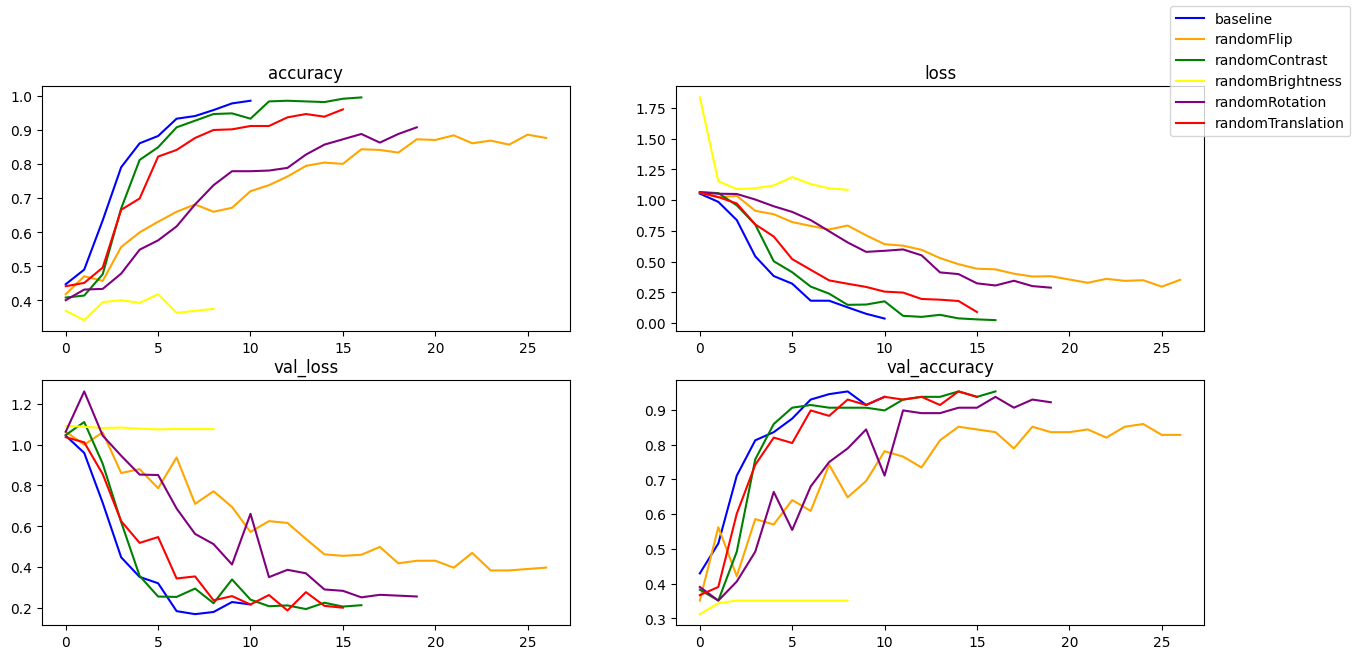

In [14]:
def evaluate_histories(histories, metrics):
    metrics_vals = []
    axs_len = int(len(metrics)/2)

    for metric in metrics:
        values = []
        for history in histories:
            val = history["history"].history[metric]
            values.append({"metric_val": val, "name": history["name"]})
        metrics_vals.append(values)


    fig, axs = plt.subplots(axs_len, axs_len, figsize=(15, 7))


    colors=["blue", "orange", "green", "yellow", "purple", "red"]
    
    metric_idx = 0
    for i in range(0, axs_len):
        for y in range(0, axs_len):
            axs[i,y].set_title(metrics[metric_idx])
            
            for x in range(0, len(metrics_vals[metric_idx])):
                axs[i, y].plot(metrics_vals[metric_idx][x]['metric_val'], colors[x], label=metrics_vals[metric_idx][x]["name"])
            
            metric_idx += 1


    # https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots
    
    handles, labels = axs.flat[len(metrics)-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    

evaluate_histories(histories, ['accuracy', 'loss', 'val_loss', 'val_accuracy'])

# Evaluation on the test set

In [27]:
def evaluate_on_test(trained_models):
    final_values = []

    for model in trained_models:
        eval_score = model['model'].evaluate(X_test, test_label, verbose=0)

        start_time = time.time()
        pred = model['model'].predict(X_test, verbose = 0)
        stop_time = time.time()

        duration = stop_time - start_time
        final_values.append({'accuracy': eval_score[1], 'inference_time': duration, 'name': model['name']})


    for value in final_values:
        print('model: ' + value['name'])
        print('Results: ' + 'Accuracy: ' + str(value['accuracy']) + ' Inference_time: ' + str(value['inference_time']) + ' Seconds')
    
    return final_values 

results = evaluate_on_test(models)

model: baseline
Results: Accuracy: 0.9375 Inference_time: 0.23560237884521484 Seconds
model: randomFlip
Results: Accuracy: 0.828125 Inference_time: 0.22763299942016602 Seconds
model: randomContrast
Results: Accuracy: 0.953125 Inference_time: 0.2193586826324463 Seconds
model: randomBrightness
Results: Accuracy: 0.3515625 Inference_time: 0.2672088146209717 Seconds
model: randomRotation
Results: Accuracy: 0.921875 Inference_time: 0.22416281700134277 Seconds
model: randomTranslation
Results: Accuracy: 0.9375 Inference_time: 0.21750330924987793 Seconds


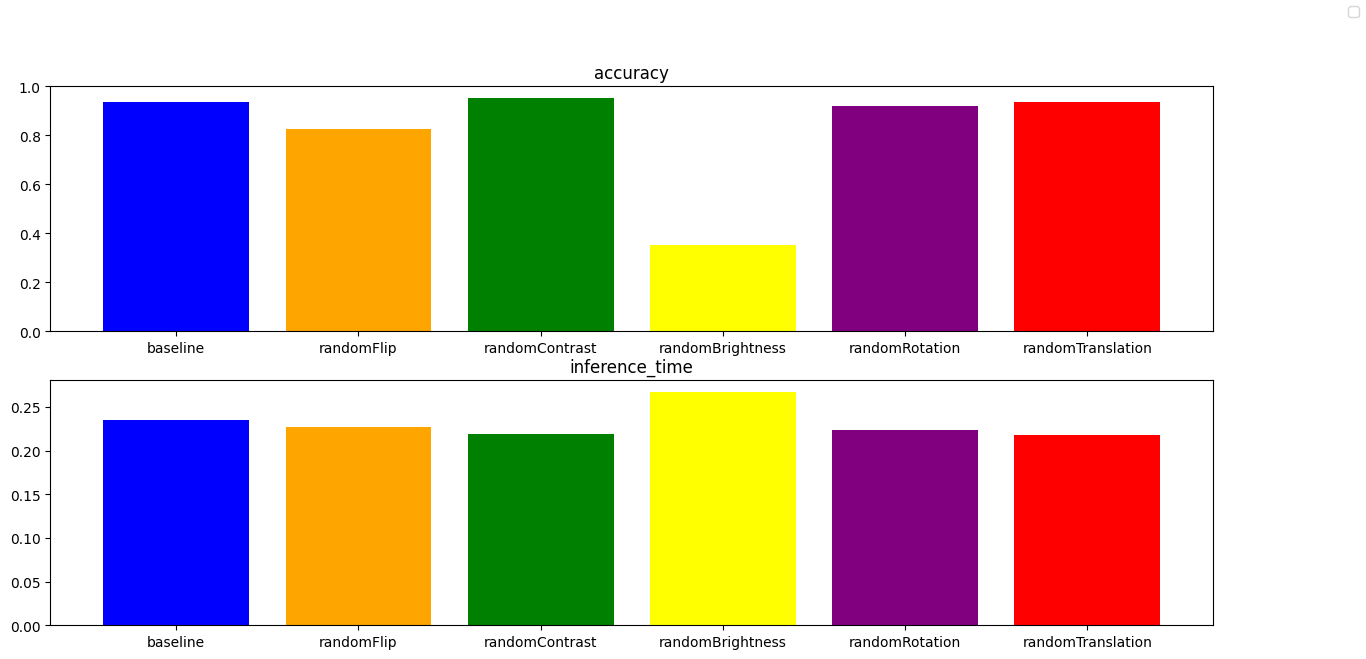

In [43]:
def evaluate_results(results, metrics):
    metrics_vals = []

    for metric in metrics:
        values = []
        for result in results:
            val = result[metric]
            values.append({"metric_val": val, "name": result["name"]})
        metrics_vals.append(values)


    fig, axs = plt.subplots(2, figsize=(15, 7))


    colors=["blue", "orange", "green", "yellow", "purple", "red"]


    
    metric_idx = 0
    for i in range(0, 2):
        axs[i].set_title(metrics[metric_idx])
        
        vals = []
        model_cats = []
        for x in range(0, len(metrics_vals[metric_idx])):
            vals.append(metrics_vals[metric_idx][x]['metric_val'])
            model_cats.append(metrics_vals[metric_idx][x]['name'])
        axs[i].bar( model_cats, vals, color=colors)
        metric_idx += 1


    # https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots
    
    handles, labels = axs.flat[len(metrics)-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    

evaluate_results(results, ['accuracy', 'inference_time'])

## Results


A surprising result is that the 'randomContrast'-layer actually increased the accuracy of the model to 93.75%. This could be because the contrast makes the hand more easily distinguishable from the background. 'RandomRotation' also performs almost as good as the baseline, as it seems the rotation doesn't worsen the classification too much. Flipping the images on the other hand, results in a drop of about 10% accuracy. Another surprise is that 'randomTranslation' also performs the same as the baseline with a value of 93.75%.
Lastly, the brightness decreased the performance even more than expected to about 35.15% before the loss function activated. As mentioned in the approach, this is probably because the classifier can no longer differentiate many pixel values and could be enhanced by decreasing the brightness-value.

As for the inference time, all models performed the same, with about 200ms. This is expected, as there is only one layer that is changed in the models and the image operation doesnt have a lot of impact on the resulting model inference time.
